In [1]:
import torch

from transformers import AutoTokenizer

model = 'distilbert/distilgpt2'
tokenizer = AutoTokenizer.from_pretrained(model)
tokenizer.pad_token = tokenizer.eos_token

In [2]:
from dataclasses import dataclass

@dataclass
class DecoderConfig:
    context:      int = 128
    vocab_size:   int = 50257
    num_layers:   int = 1
    attn_heads:   int = 4
    hidden_dim:   int = 64
    mlp_hidden:   int = 256
    mask_type:    str = 'causal'
    eos_token_id: int = 50256

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from modules import Decoder

gpt = Decoder(DecoderConfig(
    num_layers=1,
    attn_heads=4,
    hidden_dim=64,
    )).to(device)

sum([p.numel() for p in gpt.parameters()])

3274752

In [4]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

class TextGeneration(Dataset):
    def __init__(self, path, name, max_length, split = None, T = 32, **kwargs):
        self.T = T
        
        dset = load_dataset(path, name, split=split, **kwargs)
        self.len = dset.info.splits[split].num_examples
        self.dset = iter(dset)
        self.max_length = max_length
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, id):
        
        tokenized = tokenizer(
            next(self.dset)['text'],
            padding = 'max_length',
            truncation=True,
            max_length=self.max_length
            )['input_ids']
        
        if id + self.T >= self.len:
            id = self.len - self.T - 1
        
        buf = tokenized[:self.T + 1]
        inputs = torch.tensor(buf[:-1])
        target = torch.tensor(buf[1:])
        return inputs, target
    
train_set = TextGeneration(
    'wikitext', 'wikitext-103-raw-v1',
    max_length = gpt.config.context,
    split='train', streaming = True,
    T = 64
    )

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

  0%|          | 0/28147 [00:00<?, ?it/s]

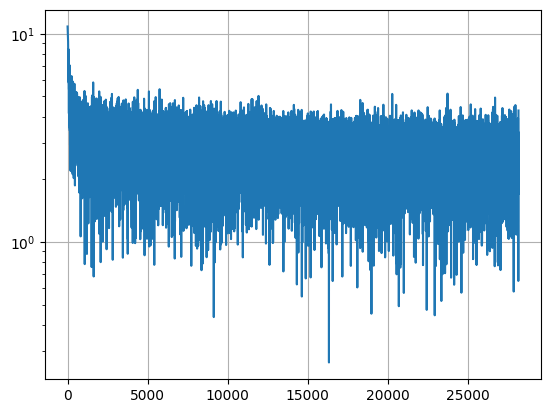

In [5]:
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

lossfn = nn.CrossEntropyLoss()
optimizer = Adam(gpt.parameters(), lr=3e-4)

loss_history = []
epochs = 1

pbar = tqdm(range(epochs * len(train_loader)))
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        
        inputs, target = [v.to(device) for v in batch]
        logits = gpt(inputs)
        loss = lossfn(logits.view(-1, logits.size(-1)), target.view(-1))
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        pbar.set_description(f'Epoch: {epoch}, loss: {loss.item():.5f}')
        pbar.update(1)
    
plt.plot(loss_history)
plt.yscale('log')
plt.grid()
plt.show()

In [6]:
torch.save(gpt, './gpt_wikitext.pt')

In [7]:
test_set = TextGeneration(
    'wikitext', 'wikitext-2-raw-v1',
    max_length = gpt.config.context,
    split='test', streaming = True,
    T = 64
    )

test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

In [19]:
inputs, targets = test_set[25]
inputs = inputs.unsqueeze(0)
print(inputs)
print(targets)

tensor([[ 5199,   347,  2852,   353,   318,   281,  3594,  2646,   837,  5581,
           290, 21421,  8674,   764,   679,   550,   257,  8319,  2488,    12,
            31, 20495,  2597,   319,   262,  5581,  2168,   383,  3941,   287,
          4751,   764,   770,   373,  3940,   416,   257, 20495,  2597,   287,
           262,   711,  2332,   684,  3194,   416, 11288, 37072,   837,   543,
           373,  6157,   287,  5878,   379,   262,  8111,  3078, 15752,   764,
           679,   550,   257,  8319]])
tensor([  347,  2852,   353,   318,   281,  3594,  2646,   837,  5581,   290,
        21421,  8674,   764,   679,   550,   257,  8319,  2488,    12,    31,
        20495,  2597,   319,   262,  5581,  2168,   383,  3941,   287,  4751,
          764,   770,   373,  3940,   416,   257, 20495,  2597,   287,   262,
          711,  2332,   684,  3194,   416, 11288, 37072,   837,   543,   373,
         6157,   287,  5878,   379,   262,  8111,  3078, 15752,   764,   679,
          550,   25

In [108]:
generated = gpt.generate(inputs.to(device), max_new_tokens=25)

decoded = (
    tokenizer.batch_decode(inputs, skip_special_tokens=True),
    tokenizer.batch_decode(generated['answer'], skip_special_tokens=True)
)

print(decoded[0][0])
print(decoded[1][0])

 Robert Boulter is an English film, television and theatre actor. He had a guest @-@ starring role on the television series The Bill in 2000. This was followed by a starring role in the play Herons written by Simon Stephens, which was performed in 2001 at the Royal Court Theatre. He had a guest
 of



In [119]:
text = 'Hello, ML&DS Community! What'

print(tokenizer.batch_decode(gpt.generate(
    tokenizer(text, return_tensors='pt')['input_ids'].to(device),
    max_new_tokens = 25
)['answer'])[0])

 had a wide long or the north @-@ lane of the state of the south of the west from Europe to the same
